In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU: CUDA")
elif torch.backends.mps.is_available():  # Check if MPS (Apple GPU) is available
    device = torch.device("mps")
    print("Using Apple GPU: MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Apple GPU: MPS


In [2]:
# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose(
    [
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2
)

In [3]:
# import torchvision.models as models

# # Load pre-trained ResNet-18 model
# model = models.resnet18(pretrained=True)

# # Modify the first convolutional layer
# model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# # Remove the first max pooling layer
# model.maxpool = nn.Identity()

# # Modify the final layer for CIFAR-10
# num_classes = 10
# model.fc = nn.Linear(model.fc.in_features, num_classes)
# model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [4]:
# def train(model, trainloader, criterion, optimizer, num_epochs=10):
#     model.train()
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         for inputs, labels in trainloader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#         scheduler.step()
#         print(
#             f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}"
#         )


# def evaluate(model, testloader):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in testloader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     print(f"Accuracy: {100 * correct / total:.2f}%")


# # Train the model
# train(model, trainloader, criterion, optimizer, num_epochs=20)

# # Evaluate the model
# evaluate(model, testloader)

# # Save the model
# torch.save(model.state_dict(), "cifar_resnet18_pretrained.pth")

In [5]:
# Create patch (random initialization)
def create_patch(patch_size=(3, 3)):
    patch = torch.randn(3, *patch_size, requires_grad=True, device=device)  # RGB
    return patch

In [6]:
def place_patch(img, patch):
    patch = patch.to(img.device)
    patched_img = img.clone()
    batch_size, _, h, w = patched_img.size()
    ph, pw = patch.size(1), patch.size(2)
    for i in range(batch_size):
        x_offset = torch.randint(0, h - ph + 1, (1,)).item()
        y_offset = torch.randint(0, w - pw + 1, (1,)).item()
        patched_img[i, :, x_offset : x_offset + ph, y_offset : y_offset + pw] = patch
    return patched_img

In [7]:
def patch_training_step(
    model, patch, target_class=None, dataloader=None, optimizer=None, criterion=None
):
    model.train()
    total_loss = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        patched_images = place_patch(images, patch)  # Apply patch to images
        outputs = model(patched_images)

        if target_class is not None:
            labels = torch.full(
                (images.size(0),), target_class, dtype=torch.long, device=device
            )
            loss = criterion(outputs, labels)
        else:
            loss = -criterion(outputs, labels)  # reverse the loss

        # loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            patch.clamp_(-1, 1)  # Ensure the patch values remain within a valid range

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [8]:
def train_adversarial_patch(
    model, patch, dataloader=None, target_class=None, num_epochs=20, lr=0.0001
):
    if dataloader is None:
        dataloader = trainloader

    patch_optimizer = optim.Adam(
        [patch], lr=lr
    )  # Use Adam optimizer for learning rate adjustment

    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        loss = patch_training_step(
            model, patch, target_class, dataloader, patch_optimizer, criterion
        )
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

In [9]:
def evaluate_patch(model, patch, dataloader, target_class=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images, patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)
            if target_class is not None:
                correct += (predicted == target_class).sum().item()
            else:
                correct += (
                    (predicted != labels).sum().item()
                )  # Evaluate untargeted attack
            total += labels.size(0)

    accuracy = 100 * correct / total

    if target_class is not None:
        print(f"Targeted Attack Success Rate (Class {target_class}): {accuracy:.2f}%")
    else:
        print(f"Untargeted Attack Success Rate: {accuracy:.2f}%")

In [10]:
target_classes = [7, 8, 9]
class_names = {7: "horse", 8: "ship", 9: "truck"}
# target_classes = [8, 9]
# class_names = {8: "ship", 9: "truck"}

### 3 by 3

In [11]:
import torchvision.models as models

model = models.resnet18(pretrained=False)
num_classes = 10

model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

checkpoint = torch.load("cifar_resnet18_pretrained.pth", map_location=device)
model.load_state_dict(checkpoint)

/Users/Lin/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Lin/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/2j/k_c_x4ps7n352tzdqvckkvb80000gn/T/ipykernel_10648/2014506944.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for

<All keys matched successfully>

In [12]:
for target_class in target_classes:
    print(
        f"\n--- Training Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )

    patch_size = (3, 3)
    patch = create_patch(patch_size)

    train_adversarial_patch(
        model=model,
        patch=patch,
        dataloader=trainloader,
        target_class=target_class,
        num_epochs=20,
        lr=0.0001,
    )

    patch_filename = f"adversarial_patch_{class_names[target_class]}_{patch_size}.pth"
    torch.save(patch.detach().cpu(), patch_filename)
    print(f"Saved patch to {patch_filename}")

    print(
        f"--- Evaluating Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    asr = evaluate_patch(
        model=model, patch=patch, dataloader=testloader, target_class=target_class
    )


--- Training Patch for Target Class: horse (7) ---
Epoch 1/20, Loss: 14.0222
Epoch 2/20, Loss: 14.0146
Epoch 3/20, Loss: 14.0037
Epoch 4/20, Loss: 13.9893
Epoch 5/20, Loss: 13.9667
Epoch 6/20, Loss: 13.9588
Epoch 7/20, Loss: 13.9552
Epoch 8/20, Loss: 13.9448
Epoch 9/20, Loss: 13.9379
Epoch 10/20, Loss: 13.9239
Epoch 11/20, Loss: 13.9095
Epoch 12/20, Loss: 13.9046
Epoch 13/20, Loss: 13.8827
Epoch 14/20, Loss: 13.8836
Epoch 15/20, Loss: 13.8791
Epoch 16/20, Loss: 13.8611
Epoch 17/20, Loss: 13.8467
Epoch 18/20, Loss: 13.8469
Epoch 19/20, Loss: 13.8294
Epoch 20/20, Loss: 13.8248
Saved patch to adversarial_patch_horse_(3, 3).pth
--- Evaluating Patch for Target Class: horse (7) ---
Targeted Attack Success Rate (Class 7): 9.95%

--- Training Patch for Target Class: ship (8) ---
Epoch 1/20, Loss: 13.6317
Epoch 2/20, Loss: 13.6143
Epoch 3/20, Loss: 13.6073
Epoch 4/20, Loss: 13.5811
Epoch 5/20, Loss: 13.5733
Epoch 6/20, Loss: 13.5598
Epoch 7/20, Loss: 13.5373
Epoch 8/20, Loss: 13.5284
Epoch 9/2

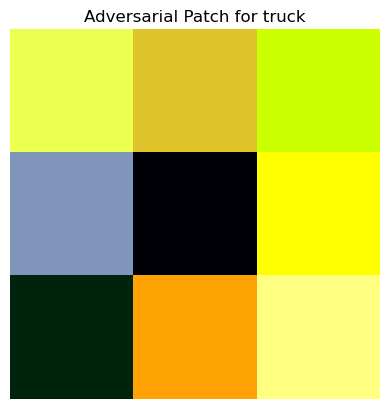

In [13]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_patch(patch, title="Adversarial Patch"):
    # Detach and move to CPU
    patch = patch.detach().cpu()
    # Convert to numpy and transpose to (H, W, C)
    patch_np = patch.permute(1, 2, 0).numpy()
    # Unnormalize if necessary
    patch_np = (patch_np * 0.5) + 0.5  # Assuming normalization was (-1, 1)
    patch_np = np.clip(patch_np, 0, 1)

    plt.imshow(patch_np)
    plt.title(title)
    plt.axis("off")
    plt.show()


# Example usage after training each patch
visualize_patch(patch, title=f"Adversarial Patch for {class_names[target_class]}")

In [14]:
# Define the class names for CIFAR-10
class_names = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

In [15]:
def denormalize(tensor, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """
    Denormalize a tensor image.

    Args:
        tensor (torch.Tensor): Normalized image tensor.
        mean (tuple): Mean used for normalization.
        std (tuple): Standard deviation used for normalization.

    Returns:
        torch.Tensor: Denormalized image tensor.
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [16]:
def visualize_misclassified_patched_images(
    model, patch, dataloader, target_class=None, num_images=5
):
    """
    Visualize misclassified images after applying the adversarial patch.

    Args:
        model (nn.Module): Trained CIFAR-10 classifier.
        patch (torch.Tensor): Trained adversarial patch.
        dataloader (DataLoader): DataLoader for evaluation data.
        target_class (int, optional): Target class for targeted attacks. Defaults to None for untargeted attacks.
        num_images (int, optional): Number of misclassified images to visualize. Defaults to 5.
    """
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images, patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)

            if target_class is not None:
                # Only include images not originally of target_class but predicted as target_class
                mask = (predicted == target_class) & (labels != target_class)
            else:
                # Untargeted Attack: Any prediction that doesn't match the true label
                mask = predicted != labels

            for i in range(images.size(0)):
                if mask[i]:
                    misclassified.append(
                        (
                            images[i].cpu(),
                            patched_images[i].cpu(),
                            labels[i].cpu(),
                            predicted[i].cpu(),
                        )
                    )
                if len(misclassified) >= num_images:
                    break
            if len(misclassified) >= num_images:
                break

    if not misclassified:
        print("No misclassified images found with the current patch.")
        return

    # Plotting
    for idx, (orig, patched, true_label, pred_label) in enumerate(misclassified):
        orig = denormalize(orig).permute(1, 2, 0).numpy()
        patched = denormalize(patched).permute(1, 2, 0).numpy()

        orig = np.clip(orig, 0, 1)
        patched = np.clip(patched, 0, 1)

        plt.figure(figsize=(4, 2))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(orig)
        plt.title(f"Original\nTrue: {class_names[true_label.item()]}")
        plt.axis("off")

        # Patched Image
        plt.subplot(1, 2, 2)
        plt.imshow(patched)
        plt.title(f"Patched\nPredicted: {class_names[pred_label.item()]}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

/var/folders/2j/k_c_x4ps7n352tzdqvckkvb80000gn/T/ipykernel_10648/2913471911.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load(patch_filename).to(device)

Targeted Attack Success Rate (Class 7): 10.25%


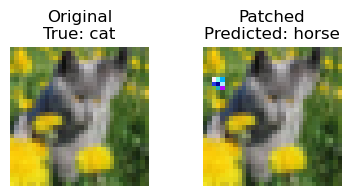

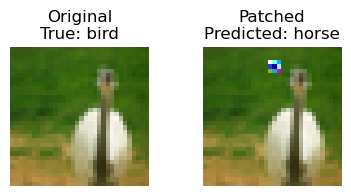

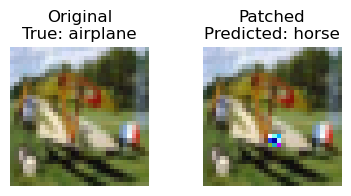

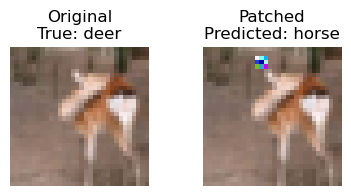

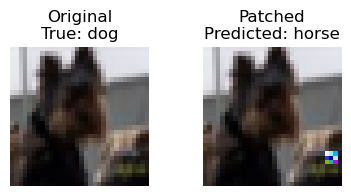

Targeted Attack Success Rate (Class 8): 9.98%


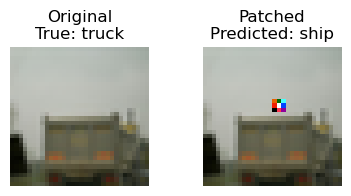

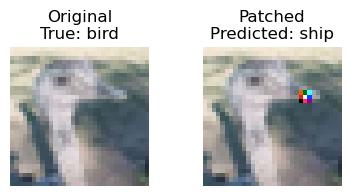

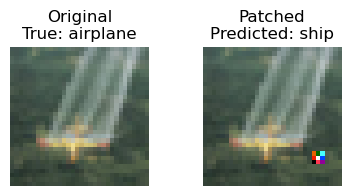

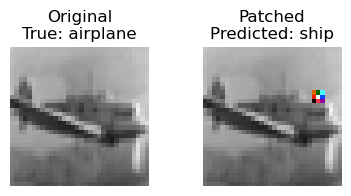

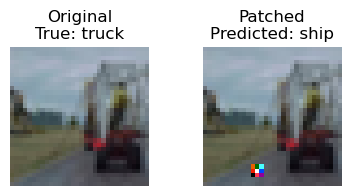

Targeted Attack Success Rate (Class 9): 9.84%


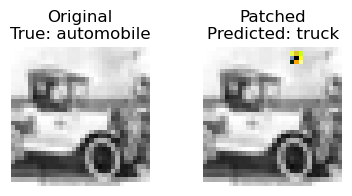

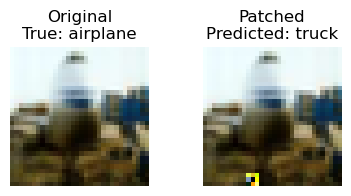

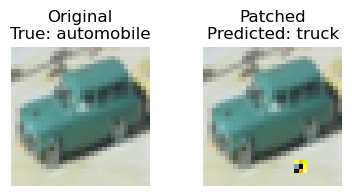

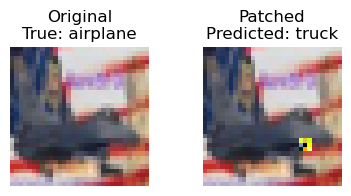

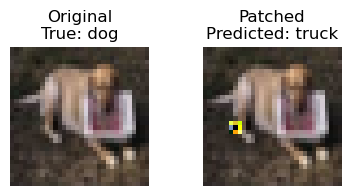

In [17]:
for target_class in target_classes:
    patch_filename = f"adversarial_patch_{class_names[target_class]}_{patch_size}.pth"

    patch = torch.load(patch_filename).to(device)

    evaluate_patch(model, patch, testloader, target_class=target_class)

    # Visualize misclassified patched images
    visualize_misclassified_patched_images(
        model=model,
        patch=patch,
        dataloader=testloader,
        target_class=target_class,
        num_images=5,  # Number of examples to visualize
    )

### 16 by 16

In [18]:
model = models.resnet18(pretrained=False)
num_classes = 10

model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

checkpoint = torch.load("cifar_resnet18_pretrained.pth", map_location=device)
model.load_state_dict(checkpoint)

/Users/Lin/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Lin/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/2j/k_c_x4ps7n352tzdqvckkvb80000gn/T/ipykernel_10648/3475114122.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for

<All keys matched successfully>

In [19]:
patch_size = (16, 16)
for target_class in target_classes:
    print(
        f"\n--- Training Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    patch = create_patch(patch_size)

    train_adversarial_patch(
        model=model,
        patch=patch,
        dataloader=trainloader,
        target_class=target_class,
        num_epochs=20,
        lr=0.0001,
    )

    patch_filename = f"adversarial_patch_{class_names[target_class]}_{patch_size}.pth"
    torch.save(patch.detach().cpu(), patch_filename)
    print(f"Saved patch to {patch_filename}")

    print(
        f"--- Evaluating Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    asr = evaluate_patch(
        model=model, patch=patch, dataloader=testloader, target_class=target_class
    )


--- Training Patch for Target Class: horse (7) ---
Epoch 1/20, Loss: 9.1820
Epoch 2/20, Loss: 9.1405
Epoch 3/20, Loss: 9.0778
Epoch 4/20, Loss: 9.0326
Epoch 5/20, Loss: 8.9818
Epoch 6/20, Loss: 8.9196
Epoch 7/20, Loss: 8.8789
Epoch 8/20, Loss: 8.8287
Epoch 9/20, Loss: 8.7626
Epoch 10/20, Loss: 8.7112
Epoch 11/20, Loss: 8.6535
Epoch 12/20, Loss: 8.6025
Epoch 13/20, Loss: 8.5527
Epoch 14/20, Loss: 8.5283
Epoch 15/20, Loss: 8.4722
Epoch 16/20, Loss: 8.4407
Epoch 17/20, Loss: 8.3885
Epoch 18/20, Loss: 8.3632
Epoch 19/20, Loss: 8.3021
Epoch 20/20, Loss: 8.2605
Saved patch to adversarial_patch_horse_(16, 16).pth
--- Evaluating Patch for Target Class: horse (7) ---
Targeted Attack Success Rate (Class 7): 9.86%

--- Training Patch for Target Class: ship (8) ---
Epoch 1/20, Loss: 8.7807
Epoch 2/20, Loss: 8.7326
Epoch 3/20, Loss: 8.6633
Epoch 4/20, Loss: 8.5609
Epoch 5/20, Loss: 8.4997
Epoch 6/20, Loss: 8.4369
Epoch 7/20, Loss: 8.3640
Epoch 8/20, Loss: 8.2875
Epoch 9/20, Loss: 8.2274
Epoch 10/2

/var/folders/2j/k_c_x4ps7n352tzdqvckkvb80000gn/T/ipykernel_10648/2913471911.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load(patch_filename).to(device)

Targeted Attack Success Rate (Class 7): 9.05%


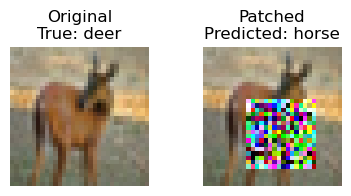

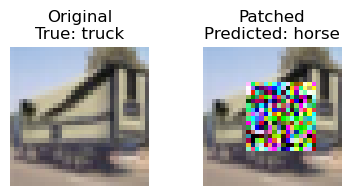

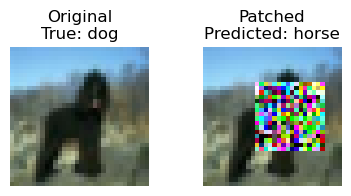

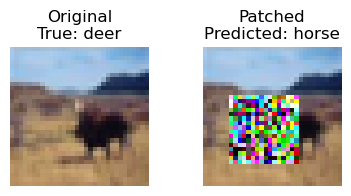

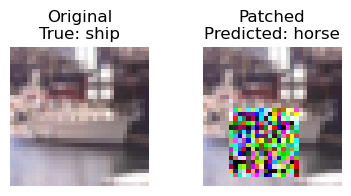

Targeted Attack Success Rate (Class 8): 8.38%


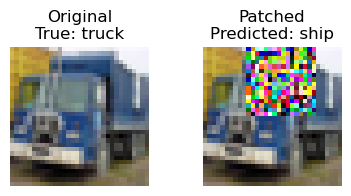

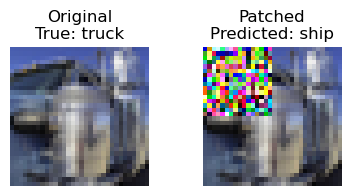

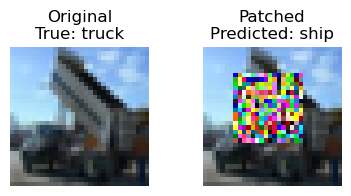

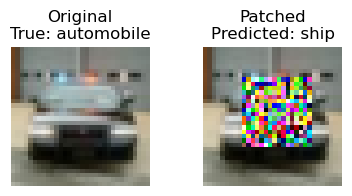

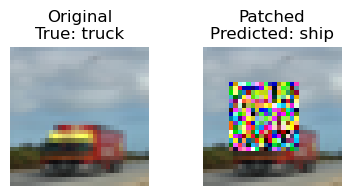

Targeted Attack Success Rate (Class 9): 13.28%


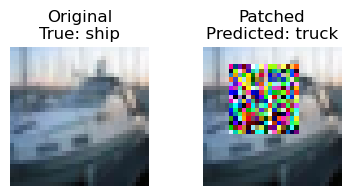

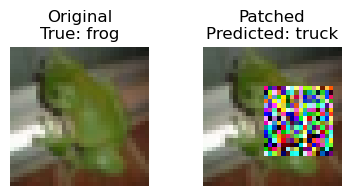

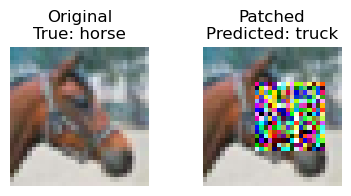

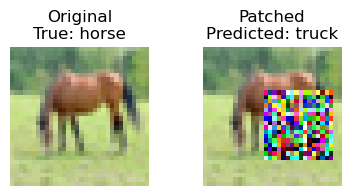

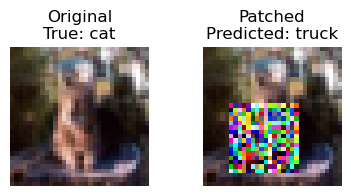

In [20]:
for target_class in target_classes:
    patch_filename = f"adversarial_patch_{class_names[target_class]}_{patch_size}.pth"

    patch = torch.load(patch_filename).to(device)

    evaluate_patch(model, patch, testloader, target_class=target_class)

    # Visualize misclassified patched images
    visualize_misclassified_patched_images(
        model=model,
        patch=patch,
        dataloader=testloader,
        target_class=target_class,
        num_images=5,  # Number of examples to visualize
    )

### 7 by 7

In [22]:
model = models.resnet18(pretrained=False)
num_classes = 10

model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

checkpoint = torch.load("cifar_resnet18_pretrained.pth", map_location=device)
model.load_state_dict(checkpoint)

/var/folders/2j/k_c_x4ps7n352tzdqvckkvb80000gn/T/ipykernel_10648/3475114122.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("cifar_resnet18_pret

<All keys matched successfully>

In [23]:
patch_size = (7, 7)
for target_class in target_classes:
    print(
        f"\n--- Training Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    patch = create_patch(patch_size)

    train_adversarial_patch(
        model=model,
        patch=patch,
        dataloader=trainloader,
        target_class=target_class,
        num_epochs=20,
        lr=0.0001,
    )

    patch_filename = f"adversarial_patch_{class_names[target_class]}_{patch_size}.pth"
    torch.save(patch.detach().cpu(), patch_filename)
    print(f"Saved patch to {patch_filename}")

    print(
        f"--- Evaluating Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    asr = evaluate_patch(
        model=model, patch=patch, dataloader=testloader, target_class=target_class
    )


--- Training Patch for Target Class: horse (7) ---
Epoch 1/20, Loss: 12.7249
Epoch 2/20, Loss: 12.6867
Epoch 3/20, Loss: 12.6401
Epoch 4/20, Loss: 12.5918
Epoch 5/20, Loss: 12.5500
Epoch 6/20, Loss: 12.4819
Epoch 7/20, Loss: 12.4253
Epoch 8/20, Loss: 12.3989
Epoch 9/20, Loss: 12.3316
Epoch 10/20, Loss: 12.3087
Epoch 11/20, Loss: 12.2678
Epoch 12/20, Loss: 12.2287
Epoch 13/20, Loss: 12.1954
Epoch 14/20, Loss: 12.1590
Epoch 15/20, Loss: 12.1258
Epoch 16/20, Loss: 12.1080
Epoch 17/20, Loss: 12.0679
Epoch 18/20, Loss: 12.0530
Epoch 19/20, Loss: 12.0048
Epoch 20/20, Loss: 11.9978
Saved patch to adversarial_patch_horse_(7, 7).pth
--- Evaluating Patch for Target Class: horse (7) ---
Targeted Attack Success Rate (Class 7): 9.80%

--- Training Patch for Target Class: ship (8) ---
Epoch 1/20, Loss: 12.4802
Epoch 2/20, Loss: 12.4427
Epoch 3/20, Loss: 12.4019
Epoch 4/20, Loss: 12.3509
Epoch 5/20, Loss: 12.3281
Epoch 6/20, Loss: 12.2776
Epoch 7/20, Loss: 12.2461
Epoch 8/20, Loss: 12.2126
Epoch 9/2

/var/folders/2j/k_c_x4ps7n352tzdqvckkvb80000gn/T/ipykernel_10648/2913471911.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load(patch_filename).to(device)

Targeted Attack Success Rate (Class 7): 8.49%


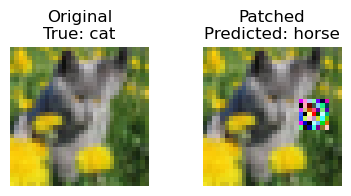

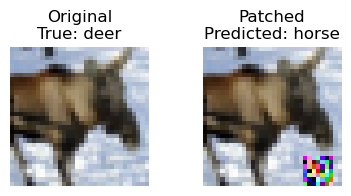

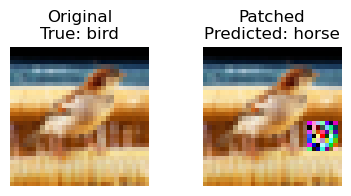

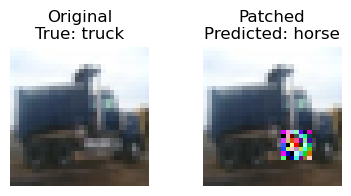

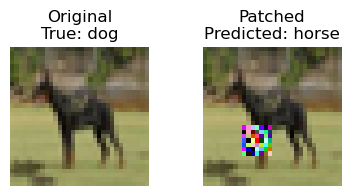

Targeted Attack Success Rate (Class 8): 10.45%


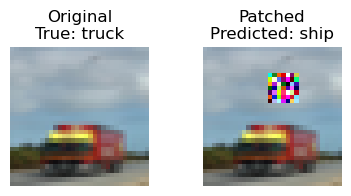

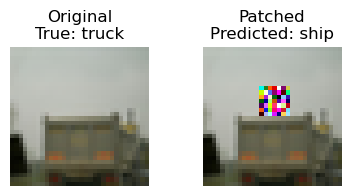

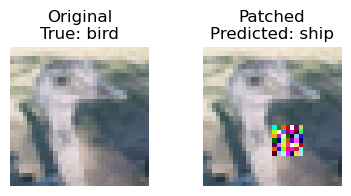

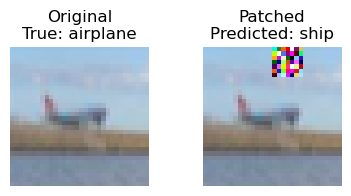

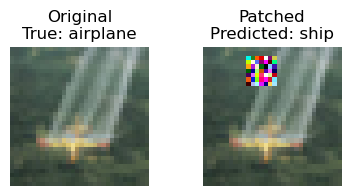

Targeted Attack Success Rate (Class 9): 10.02%


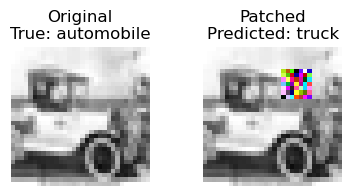

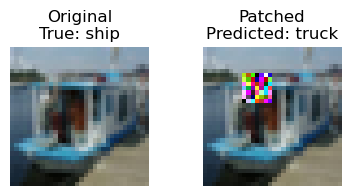

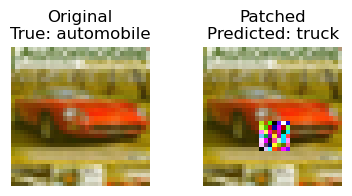

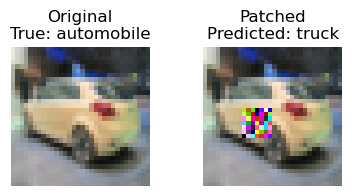

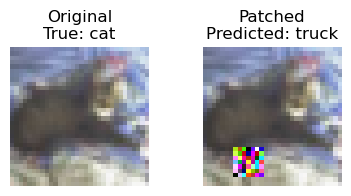

In [24]:
for target_class in target_classes:
    patch_filename = f"adversarial_patch_{class_names[target_class]}_{patch_size}.pth"

    patch = torch.load(patch_filename).to(device)

    evaluate_patch(model, patch, testloader, target_class=target_class)

    # Visualize misclassified patched images
    visualize_misclassified_patched_images(
        model=model,
        patch=patch,
        dataloader=testloader,
        target_class=target_class,
        num_images=5,  # Number of examples to visualize
    )